In [1]:
# Import ALL the things!
import pandas as pd
import pandas_gbq
import dask.dataframe as dd
import numpy as np
import pickle as pkl
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn import metrics
from scipy.stats import norm, randint
from xgboost import XGBRegressor
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [19]:
# Global variables
FW = "50"
DATASET_NAME = 'KVZ_LT_PILOT'
friday = '2019-12-13'

In [38]:
# Download training data from BigQuery into Jupyter
#query = """
#SELECT * EXCEPT (MVNDR_NBR, ORIGIN) FROM `analytics-supplychain-thd.""" + DATASET_NAME + """.TEST_SET_FNL`
#WHERE _PARTITIONTIME = '""" + friday + """'
#UNION ALL
#SELECT * EXCEPT (MVNDR_NBR, ORIGIN) FROM `analytics-supplychain-thd.""" + DATASET_NAME + """.TRAINING_SET_FNL`
#WHERE _PARTITIONDATE = '""" + friday + """'"""

query = """SELECT * EXCEPT (MVNDR_NBR, ORIGIN, FSCL_WK_NBR),
COS((FSCL_WK_NBR - 1) * 2 * ACOS(-1) / 52) as FSCL_WK_COS,
SIN((FSCL_WK_NBR - 1) * 2 * ACOS(-1) / 52) as FSCL_WK_SIN,
CASE WHEN FSCL_WK_NBR = 50 and FSCL_YR =2019
 THEN 1 ELSE 0 END AS PILOT_FLG
FROM `analytics-supplychain-thd.KVZ_LT_PILOT.FULL_DATASET` """

data = pd.read_gbq(query, 'analytics-supplychain-thd', dialect = 'standard')

(array([96319., 35047., 31412., 48453., 23548., 23114., 25736., 29038.,
        29984., 68255.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

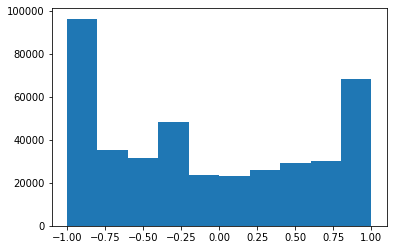

In [39]:
plt.hist(data.FSCL_WK_SIN)

In [40]:
data.columns

Index(['RECV_LOC_NBR', 'CARR_CD', 'MONTH_OF_YEAR', 'DAY_OF_WK_NBR', 'FSCL_YR',
       'TRIP_DSTN', 'PREV_WK_VENDOR_UOTC_PERF', 'WK_2_VENDOR_UOTC_PERF',
       'PREV_WK_RDC_UOTC_PERF', 'WK_2_RDC_UOTC_PERF',
       'PREV_WK_FINAL_IB_UOTC_PERF', 'WK_2_FINAL_IB_UOTC_PERF',
       'PREV_WK_COMPLETENESS', 'WK_2_COMPLETENESS', 'PREV_WK_ON_TIME_METRIC',
       'WK_2_ON_TIME_METRIC', 'TTL_IB_LT_wghtd', 'L20_AVG_VTT_ACTUAL_LT',
       'L100_AVG_VTT_ACTUAL_LT', 'L20_STD_VTT_ACTUAL_LT',
       'L100_STD_VTT_ACTUAL_LT', 'L20_AVG_VNDR_DWELL_LT_ACTUAL',
       'L100_AVG_VNDR_DWELL_LT_ACTUAL', 'L20_STD_VNDR_DWELL_LT_ACTUAL',
       'L100_STD_VNDR_DWELL_LT_ACTUAL', 'L20_AVG_CARRIER_RDC_IB_ACTUAL_LT',
       'L100_AVG_CARRIER_RDC_IB_ACTUAL_LT', 'L20_STD_CARRIER_RDC_IB_ACTUAL_LT',
       'L100_STD_CARRIER_RDC_IB_ACTUAL_LT', 'L20_AVG_RDC_IB_ACT_LT',
       'L100_AVG_RDC_IB_ACT_LT', 'L20_STD_RDC_IB_ACT_LT',
       'L100_STD_RDC_IB_ACT_LT', 'L20_AVG_TTL_IB_LT_wghtd',
       'L100_AVG_TTL_IB_LT_wghtd', 'L20_

In [41]:
# One-hot encode all categorical variables
cat_cols =['RECV_LOC_NBR','CARR_CD','MONTH_OF_YEAR',
            'DAY_OF_WK_NBR']

data[cat_cols] = data[cat_cols].apply(lambda x: x.astype('category'))
data = pd.get_dummies(data, columns = cat_cols, drop_first = True)

# Log-transform of inbound leadtime
data.TTL_IB_LT_wghtd = np.log( data.TTL_IB_LT_wghtd * 24 * 60)

# Upload one-hot encoded data back into BigQuery
# pandas_gbq.to_gbq(data, DATASET_NAME + '.TESTING_OUTPUT', project_id='analytics-supplychain-thd', if_exists = 'replace')

In [ ]:
def mae(y_true, y_pred):
    y_pred = (np.exp(y_pred)/(24*60))
    y_true = (np.exp(y_true)/(24*60))
    return np.mean(y_true - y_pred))
    
    

In [42]:
# Split into test-train
#df = data[data['FSCL_WK_NBR_' + FW] == 0]
#df2 = data[data['FSCL_WK_NBR_' + FW] == 1]

df = data[data['PILOT_FLG'] == 0]
df2 = data[data['PILOT_FLG'] == 1]

# Set up cross-fold validation with random seed for reproducibility
seed = 9102020 #9102018
kfold = KFold(n_splits=5, random_state=seed)

# Our result metrics
def mae(y_true, y_pred):
    y_pred=(np.exp(y_pred)/(24*60))
    y_true =(np.exp(y_true)/(24*60)) 
    return  (mean_absolute_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_pred=(np.exp(y_pred)/(24*60)).round(2)
    y_true =(np.exp(y_true)/(24*60)).round(2)   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return ((sum(   np.abs((y_true - y_pred)) )/sum( y_true)) *100)
    return   -( np.sum( np.abs(y_true- y_pred)/y_true )/len(y_true)  )*100 

def mean_percentage_error(y_true, y_pred): 
    y_pred=(np.exp(y_pred)/(24*60))
    y_true =(np.exp(y_true)/(24*60))
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((sum((y_true - y_pred) )/ sum(y_true) ) *100)

# Turn the functions above into official scorer objects - smaller value is better (?)
mape_scorer = make_scorer (mean_absolute_percentage_error, greater_is_better= False)
mpe_scorer = make_scorer (mean_percentage_error, greater_is_better= False)
mae_scorer = make_scorer(mae, greater_is_better= False)

scoring = {'mae': mae_scorer,
           'mape': mape_scorer,
           'mpe': mpe_scorer}


In [37]:
scoring 

{'mae': make_scorer(mae, greater_is_better=False),
 'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
 'mpe': make_scorer(mean_percentage_error, greater_is_better=False)}

In [45]:
params = {  
    "n_estimators": randint(50, 100),
    "max_depth": randint(5, 10),
    "learning_rate": [0.05, 0.1, 0.2, 0.3],
}

# Predict TTL_IB_LT_wghtd
# n_iter is number of times to pick things from params
# refit = mape means find best (smallest) mape
xgbreg = XGBRegressor(base_score = np.mean(df.TTL_IB_LT_wghtd),\
#        objective='reg:linear',
                      missing=None,random_state=seed, n_jobs = 4, verbose = 10) 
xgbrandomsearch = RandomizedSearchCV(xgbreg,params,n_iter=10, scoring=scoring, cv = kfold, refit = 'mape', verbose = 10)  
xgbreg.fit(df[df.columns.difference(['TTL_IB_LT_wghtd', 'PILOT_FLG', \
                                              'ORD_ID'])],df.TTL_IB_LT_wghtd)
xgbrandomsearch.fit(df[df.columns.difference(['TTL_IB_LT_wghtd', 'PILOT_FLG', \
                                              'ORD_ID'])],df.TTL_IB_LT_wghtd)



C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:47:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=7, n_estimators=91 .................
[16:50:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=7, n_estimators=91, mae=-1.369, mape=22.964, mpe=-9.396, total=971.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 971.6min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=7, n_estimators=91 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:01:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=7, n_estimators=91, mae=-1.144, mape=19.240, mpe=-2.952, total= 4.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 976.2min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=7, n_estimators=91 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=7, n_estimators=91, mae=-1.213, mape=19.084, mpe=-3.630, total= 4.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 980.3min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=7, n_estimators=91 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:10:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=7, n_estimators=91, mae=-1.179, mape=19.678, mpe=-3.901, total= 4.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 984.4min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=7, n_estimators=91 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=7, n_estimators=91, mae=-1.188, mape=19.640, mpe=-2.699, total= 4.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 988.9min remaining:    0.0s


[CV] learning_rate=0.2, max_depth=7, n_estimators=78 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:19:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.2, max_depth=7, n_estimators=78, mae=-1.430, mape=23.730, mpe=-10.507, total= 3.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 992.3min remaining:    0.0s


[CV] learning_rate=0.2, max_depth=7, n_estimators=78 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.2, max_depth=7, n_estimators=78, mae=-1.142, mape=19.194, mpe=-2.621, total= 3.5min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 995.8min remaining:    0.0s


[CV] learning_rate=0.2, max_depth=7, n_estimators=78 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.2, max_depth=7, n_estimators=78, mae=-1.208, mape=19.031, mpe=-3.458, total= 3.6min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 999.3min remaining:    0.0s


[CV] learning_rate=0.2, max_depth=7, n_estimators=78 .................


C:\Users\yxg0rzh\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [44]:
# Find best model and save resulting predictions to CSV
best_xgb_model= xgbrandomsearch.best_estimator_

df['predictions'] = np.exp( best_xgb_model.predict(df[df.columns.difference(['TTL_IB_LT_wghtd','ORD_ID'])])  )/(24*60)
##df[['ORD_ID','predictions']].to_csv('NO_RDC_' + FW + '_TOTAL.csv', sep='\t', index = False)  ## change week here

df2['predictions'] = np.exp( best_xgb_model.predict(df2[df2.columns.difference(['TTL_IB_LT_wghtd','ORD_ID'])])  )/(24*60)
##df2[['ORD_ID','predictions']].to_csv('NO_RDC_' + FW + '_FW.csv', sep='\t', index = False)  ## change week here



AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [8]:
# Also save predictions to BigQuery
pandas_gbq.to_gbq(df[['ORD_ID','predictions']], DATASET_NAME + '.NO_RDC_' + FW + '_TOTAL', project_id='analytics-supplychain-thd', if_exists = 'replace')
pandas_gbq.to_gbq(df2[['ORD_ID','predictions']], DATASET_NAME + '.NO_RDC_' + FW + '_WK', project_id='analytics-supplychain-thd', if_exists = 'replace')

In [9]:
# CAR analysis!!!

helluva_query = """WITH ML AS (SELECT
    MVNDR_NBR,
    RDC_NBR,
    R.STR_NBR,
    FSCL_WK_END_DT,
    DC_OUTB_SLTM_DAYS + predictions  AS ML_LT,
    DC_OUTB_SLTM_DAYS + TTL_IB_LT_wghtd AS ACT_LT,
    DC_OUTB_SLTM_DAYS + MV_OUTB_LTM_QTY AS CAR_LT
  FROM
    `analytics-supplychain-thd.""" + DATASET_NAME + """.NO_RDC_""" + FW + """_WK` A
  JOIN
    `analytics-supplychain-thd.""" + DATASET_NAME + """.TRAINING_SET_FNL` B
  ON
    A.ORD_ID = B.ORD_ID
  JOIN
    `analytics-supplychain-thd.AAA_VIEWS.STR_RDC` R
  ON
    B.RECV_LOC_NBR = R.RDC_NBR
  JOIN
    `pr-edw-views-thd.SHARED.FSCL_WK_HIER_FD` F
  ON
    B.FSCL_WK_NBR = F.FSCL_WK_NBR
    AND F.FSCL_WK_END_DT > '"""+ friday +"""'
  JOIN
    `pr-edw-views-thd.SCHN_INV.CRE_BUMV_LTM` C
  ON
    B.MVNDR_NBR = C.CRE_MVNDR_NBR
    AND R.STR_NBR = C.STR_NBR
    AND F.FSCL_WK_END_DT = C.WK_END_DT),
  FL AS (SELECT
  DISTINCT MVNDR_NBR,
  RECV_LOC_NBR AS RDC_NBR,
  COUNT(*) AS HIST_DATA_CNT,
  MIN(CASE WHEN FSCL_WK_NBR > """+ FW +""" THEN 201800 + FSCL_WK_NBR ELSE 201900 + FSCL_WK_NBR END) AS FIRST_ORD,
  MAX(CASE WHEN FSCL_WK_NBR > """+ FW +""" THEN 201800 + FSCL_WK_NBR ELSE 201900 + FSCL_WK_NBR END) AS LAST_ORD,
  MAX(CASE WHEN FSCL_WK_NBR > """+ FW +""" THEN  FSCL_WK_NBR ELSE 52+ FSCL_WK_NBR END) - MIN(CASE WHEN FSCL_WK_NBR > """+ FW +""" THEN  FSCL_WK_NBR ELSE 52 + FSCL_WK_NBR END)+ 1 AS NUM_WEEKS
FROM
  `analytics-supplychain-thd.""" + DATASET_NAME + """.TRAINING_SET_FNL`
GROUP BY
  1,
  2),
  
CAR_RESULTS AS (SELECT ML.FSCL_WK_END_DT, ML.MVNDR_NBR, ML.RDC_NBR, HIST_DATA_CNT, NUM_WEEKS, ML_LT, ACT_LT, CAR_LT,
  SUM((ML_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS ML_CYCLE,
  SUM((ACT_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS ACT_CYCLE,
  SUM((CAR_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS CAR_CYCLE
FROM
  ML
JOIN
  `pr-edw-views-thd.SCHN_INV.CAR_PARM_WKLY` C
ON
  ML.MVNDR_NBR = C.MVNDR_NBR
  AND ML.FSCL_WK_END_DT = C.FSCL_WK_END_DT
  AND ML.STR_NBR = C.STR_NBR
JOIN FL ON FL.MVNDR_NBR = ML.MVNDR_NBR AND ML.RDC_NBR = FL.RDC_NBR
GROUP BY 1,2,3,4,5,6,7,8 ORDER BY FSCL_WK_END_DT),

OVER_TIME_AVG AS (SELECT
  MVNDR_NBR,
  RDC_NBR,
  HIST_DATA_CNT,
  NUM_WEEKS,
  AVG(ML_LT) AS ML_LT,
  AVG(ACT_LT) AS ACT_LT,
  AVG(CAR_LT) AS CAR_LT,
  AVG(ML_CYCLE) AS ML_CYCLE,
  AVG(ACT_CYCLE) AS ACT_CYCLE,
  AVG(CAR_CYCLE) AS CAR_CYCLE,
  AVG(ABS(ML_LT - ACT_LT)/ACT_LT) AS ML_MAPE,
  AVG(ABS(CAR_LT - ACT_LT)/ACT_LT) AS CAR_MAPE
FROM
  CAR_RESULTS
GROUP BY
  1,
  2,
  3,
  4
ORDER BY
  1,
  2),
  
AGG AS (SELECT MVNDR_NBR,
  RDC_NBR,
  HIST_DATA_CNT,
  NUM_WEEKS,
  AVG(ML_LT) AS ML_LT,
  AVG(ACT_LT) AS ACT_LT,
  AVG(CAR_LT) AS CAR_LT,
   ML_MAPE,
   CAR_MAPE,
  SUM(ML_CYCLE) AS ML_CYCLE,
  SUM(ACT_CYCLE) AS ACT_CYCLE,
  SUM(CAR_CYCLE) AS CAR_CYCLE,
  (SUM(ML_CYCLE) - SUM(CAR_CYCLE))/SUM(CAR_CYCLE) as PERCENT_DIFF
FROM OVER_TIME_AVG
GROUP BY 1,2,3,4, ML_MAPE, CAR_MAPE
ORDER BY PERCENT_DIFF),


FLAGS AS (SELECT
  MVNDR_NBR,
  RECV_LOC_NBR,
  CASE
    WHEN AVG(L100_STD_VTT_ACTUAL_LT) > 1 THEN 'HIGH_VTT_VAR'
  ELSE
  'LOW_VTT_VAR' END
  AS STD_DEV_FLG,
  CASE WHEN AVG(DIST_km) < 10000 THEN 'SHORT_DIST' ELSE 'LONG_DIST' END AS DISTANCE

FROM
  `analytics-supplychain-thd.""" + DATASET_NAME + """.TRAINING_SET_FNL` A
JOIN
  `analytics-supplychain-thd.""" + DATASET_NAME + """.NO_RDC_""" + FW + """_WK` B
ON
  A.ORD_ID = B.ORD_ID
GROUP BY 1,2)

SELECT 
AGG.MVNDR_NBR,
MVNDR_NM,
DEPT_NBR,
RDC_NBR,
HIST_DATA_CNT,
CASE WHEN HIST_DATA_CNT >= 25 AND NUM_WEEKS >= 40 THEN 'REGULAR(25+/40+)'
            WHEN HIST_DATA_CNT > 8 AND HIST_DATA_CNT < 25 AND NUM_WEEKS > 8 AND NUM_WEEKS < 40 THEN 'EXISTS(8-25/8-40)'
            ELSE 'VERY LITTLE(8-/8-)' END AS FIDELITY, 
            STD_DEV_FLG AS VTT_VAR,
            DISTANCE AS DIST_VAR,
            AVG(ML_LT) AS ML_LT,
            AVG(ACT_LT) AS ACT_LT,
            AVG(CAR_LT) AS CAR_LT,
            AVG(ML_CYCLE) AS ML_CYCLE,
            AVG(ACT_CYCLE) AS ACT_CYCLE,
            AVG(CAR_CYCLE) AS CAR_CYCLE,
            AVG(ABS(ML_LT - ACT_LT)/ACT_LT) AS ML_MAPE,
            AVG(ABS(CAR_LT - ACT_LT)/ACT_LT) AS CAR_MAPE,
            AVG(ML_LT - ACT_LT) AS ML_DIFF,
            AVG(CAR_LT - ACT_LT) AS CAR_DIFF
FROM AGG 
JOIN FLAGS ON AGG.MVNDR_NBR = FLAGS.MVNDR_NBR AND AGG.RDC_NBR = FLAGS.RECV_LOC_NBR 
JOIN `pr-edw-views-thd.SHARED.MVNDR_HIER_FD` C ON AGG.MVNDR_NBR = C.MVNDR_NBR
GROUP BY 1,2,3,4,5,6,7,8 ORDER BY 1,2"""


In [10]:
# Run CAR analysis and also export to bigquery
analysis = pd.read_gbq(helluva_query, 'analytics-supplychain-thd', dialect = 'standard')
analysis.to_csv('NO_RDC_' + FW + '_WK_ANALYSIS.csv', sep=',', index = False)
pandas_gbq.to_gbq(analysis, DATASET_NAME + '.NO_RDC_' + FW + '_WK_ANALYSIS', project_id='analytics-supplychain-thd', if_exists = 'replace')

GenericGBQException: Reason: 400 Unrecognized name: DIST_km at [108:17]

(job ID: c02e319d-4e58-424f-9b19-ca4684f00411)

                                                                        -----Query Job SQL Follows-----                                                                        

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:WITH ML AS (SELECT
   2:    MVNDR_NBR,
   3:    RDC_NBR,
   4:    R.STR_NBR,
   5:    FSCL_WK_END_DT,
   6:    DC_OUTB_SLTM_DAYS + predictions  AS ML_LT,
   7:    DC_OUTB_SLTM_DAYS + TTL_IB_LT_wghtd AS ACT_LT,
   8:    DC_OUTB_SLTM_DAYS + MV_OUTB_LTM_QTY AS CAR_LT
   9:  FROM
  10:    `analytics-supplychain-thd.KVZ_LT_PILOT.NO_RDC_46_WK` A
  11:  JOIN
  12:    `analytics-supplychain-thd.KVZ_LT_PILOT.TRAINING_SET_FNL` B
  13:  ON
  14:    A.ORD_ID = B.ORD_ID
  15:  JOIN
  16:    `analytics-supplychain-thd.AAA_VIEWS.STR_RDC` R
  17:  ON
  18:    B.RECV_LOC_NBR = R.RDC_NBR
  19:  JOIN
  20:    `pr-edw-views-thd.SHARED.FSCL_WK_HIER_FD` F
  21:  ON
  22:    B.FSCL_WK_NBR = F.FSCL_WK_NBR
  23:    AND F.FSCL_WK_END_DT > '2019-12-13'
  24:  JOIN
  25:    `pr-edw-views-thd.SCHN_INV.CRE_BUMV_LTM` C
  26:  ON
  27:    B.MVNDR_NBR = C.CRE_MVNDR_NBR
  28:    AND R.STR_NBR = C.STR_NBR
  29:    AND F.FSCL_WK_END_DT = C.WK_END_DT),
  30:  FL AS (SELECT
  31:  DISTINCT MVNDR_NBR,
  32:  RECV_LOC_NBR AS RDC_NBR,
  33:  COUNT(*) AS HIST_DATA_CNT,
  34:  MIN(CASE WHEN FSCL_WK_NBR > 46 THEN 201800 + FSCL_WK_NBR ELSE 201900 + FSCL_WK_NBR END) AS FIRST_ORD,
  35:  MAX(CASE WHEN FSCL_WK_NBR > 46 THEN 201800 + FSCL_WK_NBR ELSE 201900 + FSCL_WK_NBR END) AS LAST_ORD,
  36:  MAX(CASE WHEN FSCL_WK_NBR > 46 THEN  FSCL_WK_NBR ELSE 52+ FSCL_WK_NBR END) - MIN(CASE WHEN FSCL_WK_NBR > 46 THEN  FSCL_WK_NBR ELSE 52 + FSCL_WK_NBR END)+ 1 AS NUM_WEEKS
  37:FROM
  38:  `analytics-supplychain-thd.KVZ_LT_PILOT.TRAINING_SET_FNL`
  39:GROUP BY
  40:  1,
  41:  2),
  42:  
  43:CAR_RESULTS AS (SELECT ML.FSCL_WK_END_DT, ML.MVNDR_NBR, ML.RDC_NBR, HIST_DATA_CNT, NUM_WEEKS, ML_LT, ACT_LT, CAR_LT,
  44:  SUM((ML_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS ML_CYCLE,
  45:  SUM((ACT_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS ACT_CYCLE,
  46:  SUM((CAR_LT + REV_TM_DAYS_CNT)/(LEAD_TM_DAYS + REV_TM_DAYS_CNT) * CURR_RETL_AMT * (LEAD_TM_QTY + REV_TM_QTY)) AS CAR_CYCLE
  47:FROM
  48:  ML
  49:JOIN
  50:  `pr-edw-views-thd.SCHN_INV.CAR_PARM_WKLY` C
  51:ON
  52:  ML.MVNDR_NBR = C.MVNDR_NBR
  53:  AND ML.FSCL_WK_END_DT = C.FSCL_WK_END_DT
  54:  AND ML.STR_NBR = C.STR_NBR
  55:JOIN FL ON FL.MVNDR_NBR = ML.MVNDR_NBR AND ML.RDC_NBR = FL.RDC_NBR
  56:GROUP BY 1,2,3,4,5,6,7,8 ORDER BY FSCL_WK_END_DT),
  57:
  58:OVER_TIME_AVG AS (SELECT
  59:  MVNDR_NBR,
  60:  RDC_NBR,
  61:  HIST_DATA_CNT,
  62:  NUM_WEEKS,
  63:  AVG(ML_LT) AS ML_LT,
  64:  AVG(ACT_LT) AS ACT_LT,
  65:  AVG(CAR_LT) AS CAR_LT,
  66:  AVG(ML_CYCLE) AS ML_CYCLE,
  67:  AVG(ACT_CYCLE) AS ACT_CYCLE,
  68:  AVG(CAR_CYCLE) AS CAR_CYCLE,
  69:  AVG(ABS(ML_LT - ACT_LT)/ACT_LT) AS ML_MAPE,
  70:  AVG(ABS(CAR_LT - ACT_LT)/ACT_LT) AS CAR_MAPE
  71:FROM
  72:  CAR_RESULTS
  73:GROUP BY
  74:  1,
  75:  2,
  76:  3,
  77:  4
  78:ORDER BY
  79:  1,
  80:  2),
  81:  
  82:AGG AS (SELECT MVNDR_NBR,
  83:  RDC_NBR,
  84:  HIST_DATA_CNT,
  85:  NUM_WEEKS,
  86:  AVG(ML_LT) AS ML_LT,
  87:  AVG(ACT_LT) AS ACT_LT,
  88:  AVG(CAR_LT) AS CAR_LT,
  89:   ML_MAPE,
  90:   CAR_MAPE,
  91:  SUM(ML_CYCLE) AS ML_CYCLE,
  92:  SUM(ACT_CYCLE) AS ACT_CYCLE,
  93:  SUM(CAR_CYCLE) AS CAR_CYCLE,
  94:  (SUM(ML_CYCLE) - SUM(CAR_CYCLE))/SUM(CAR_CYCLE) as PERCENT_DIFF
  95:FROM OVER_TIME_AVG
  96:GROUP BY 1,2,3,4, ML_MAPE, CAR_MAPE
  97:ORDER BY PERCENT_DIFF),
  98:
  99:
 100:FLAGS AS (SELECT
 101:  MVNDR_NBR,
 102:  RECV_LOC_NBR,
 103:  CASE
 104:    WHEN AVG(L100_STD_VTT_ACTUAL_LT) > 1 THEN 'HIGH_VTT_VAR'
 105:  ELSE
 106:  'LOW_VTT_VAR' END
 107:  AS STD_DEV_FLG,
 108:  CASE WHEN AVG(DIST_km) < 10000 THEN 'SHORT_DIST' ELSE 'LONG_DIST' END AS DISTANCE
 109:
 110:FROM
 111:  `analytics-supplychain-thd.KVZ_LT_PILOT.TRAINING_SET_FNL` A
 112:JOIN
 113:  `analytics-supplychain-thd.KVZ_LT_PILOT.NO_RDC_46_WK` B
 114:ON
 115:  A.ORD_ID = B.ORD_ID
 116:GROUP BY 1,2)
 117:
 118:SELECT 
 119:AGG.MVNDR_NBR,
 120:MVNDR_NM,
 121:DEPT_NBR,
 122:RDC_NBR,
 123:HIST_DATA_CNT,
 124:CASE WHEN HIST_DATA_CNT >= 25 AND NUM_WEEKS >= 40 THEN 'REGULAR(25+/40+)'
 125:            WHEN HIST_DATA_CNT > 8 AND HIST_DATA_CNT < 25 AND NUM_WEEKS > 8 AND NUM_WEEKS < 40 THEN 'EXISTS(8-25/8-40)'
 126:            ELSE 'VERY LITTLE(8-/8-)' END AS FIDELITY, 
 127:            STD_DEV_FLG AS VTT_VAR,
 128:            DISTANCE AS DIST_VAR,
 129:            AVG(ML_LT) AS ML_LT,
 130:            AVG(ACT_LT) AS ACT_LT,
 131:            AVG(CAR_LT) AS CAR_LT,
 132:            AVG(ML_CYCLE) AS ML_CYCLE,
 133:            AVG(ACT_CYCLE) AS ACT_CYCLE,
 134:            AVG(CAR_CYCLE) AS CAR_CYCLE,
 135:            AVG(ABS(ML_LT - ACT_LT)/ACT_LT) AS ML_MAPE,
 136:            AVG(ABS(CAR_LT - ACT_LT)/ACT_LT) AS CAR_MAPE,
 137:            AVG(ML_LT - ACT_LT) AS ML_DIFF,
 138:            AVG(CAR_LT - ACT_LT) AS CAR_DIFF
 139:FROM AGG 
 140:JOIN FLAGS ON AGG.MVNDR_NBR = FLAGS.MVNDR_NBR AND AGG.RDC_NBR = FLAGS.RECV_LOC_NBR 
 141:JOIN `pr-edw-views-thd.SHARED.MVNDR_HIER_FD` C ON AGG.MVNDR_NBR = C.MVNDR_NBR
 142:GROUP BY 1,2,3,4,5,6,7,8 ORDER BY 1,2
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |

In [ ]:
pip install pandas_gbq

In [ ]:
pip install --upgrade google-cloud-bigquery

In [ ]:
pip install --upgrade six